# Data cleaning and importing

Data cleaning and importing happen in the next few cells.

At the top of each cell is a flag. Set it `true` to reprocess the data and `false` to just load the data. 

Some of the steps take a while, so be forewarned. 

## Step 1. Set imports and directories.

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import scipy.io
from scipy import stats
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm


# Set paths
baseDir = os.path.join(os.getcwd(),'..')
codeDir = os.path.join(baseDir, 'code')
dataDir = os.path.join(baseDir, 'data')
stimDir = os.path.join(baseDir, 'BOLD5000_Stimuli_Shared')

# Import helper functions
os.chdir(codeDir)

### Step 1a. Function that will take in the master data and save the participant's drawings.

In [2]:

"""
Helper functions for processing the catScenes data
"""
from itertools import cycle
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Function that takes in a single participant's sketch
def analogDirCheck(masterData, index,showPlot=False):
    """
    Takes in an index and the height of the participant's drawing.
    Plots that drawing as a figure with a fixed size (correcting for height of the participant's monitor).
    Captures an image of that plot.
    Saves the plot as pixel data where 1 means the participant drew there. 0 means they did not.
    masterData = Psychopy trial level data (each row is a trial from the analog experiment)
    index = index of the drawing in the dataframe
    height = height of the participant's monitor (from masterData)
    """

    # Grab the sketch at this index
    sketch = masterData.loc[index,'drawingFixed']
    px = []
    py = []

    # For every point in sketch, create a list of x and y coordinates
    for i,j in enumerate(sketch):
        px.append([])
        py.append([])
        for k,l in enumerate(j):
            px[i].append(l[0])
            py[i].append(l[1])

    # Colors for visualization (if showPlots is True)
    colors = cycle(['red','blue','green','purple','pink'])

    # Plot these things on a standard scale 
    fig,ax = plt.subplots(figsize=[1,1],dpi=100)
    canvas = FigureCanvas(fig)
    ax = fig.gca()

    # Turn the axis off
    ax.axis('off')

    # Plot each point, adjusting for height again. 
    for i,j in enumerate(px):
        ax.plot(px[i],py[i],color=next(colors))
        # These numbers come from the original presentation position of the images.
        ax.set_xlim(-.35,.35)
        ax.set_ylim(-.25,.45)

    # Save the plot as a list of on/off pixels (binarized)
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    ncols, nrows = canvas.get_width_height()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8).reshape((ncols, nrows, 3))
    data = np.mean(data,axis=2)

    # Binarize
    data = np.where(data < 254.99, 1, data)
    data = np.where(data > 254.99, 0, data)

    if not showPlot:
        plt.close('all')
    if showPlot:
        plt.show()

    # Return the data as a vector. 
    return data.reshape(data.size)


## Step 2. Import the master data.
This is the concatenated data from Psychopy where each row is a trial. There are loads of non-trial rows here as well, so some data cleaning is necessary before analysis. 

In [3]:
# Change this to false if you edit the load sequence
createMasterData = False

if not os.path.exists(os.path.join(dataDir,'masterData.csv')) or createMasterData:
    
    # This directory contains only the raw data for participants who should be included in the analyses.
    rawDataDir = os.path.join(dataDir,'toAnalyze')

    dataFiles = os.listdir(rawDataDir)

    # Get all data files
    dataFileNames = [x for x in dataFiles if 'csv' in x]
    print(f'Processing {len(dataFiles)} files.')
    
    # Load all data files in.
    for i,fileName in enumerate(dataFileNames):
        with open (rawDataDir + os.path.sep + fileName, "r") as myfile:
            participantData = pd.read_csv(myfile,sep=',')
            participantData.rename(columns={participantData.iloc[(3,0)]: "presentedImage"},inplace=True)
    
        # For the first dataset, just create the dataFrame
        if i < 1:
            masterData = participantData.copy()
            masterData.rename(columns={masterData.iloc[(3,0)]: "presentedImage"},inplace=True)
        # Concatenate the rest
        else:
            masterData = pd.concat([masterData,participantData])
    
    masterData.reset_index(inplace=True)
    
    # Fix the drawing values to save better. 
    masterData['drawingFixed'] = np.nan
    masterData['drawingFixed'] = masterData['drawingFixed'].astype('object')
    masterData['drawingCoded'] = np.nan
    masterData['drawingCoded'] = masterData['drawingCoded'].astype('object')
    # Adding columns for the ling coding
    masterData['ahead'] = np.nan
    masterData['left'] = np.nan
    masterData['sharp_left'] = np.nan
    masterData['slight_left'] = np.nan
    masterData['sharp_right'] = np.nan
    masterData['right'] = np.nan
    masterData['slight_right'] = np.nan
    
    
    for index,row in masterData.iterrows():
        if not pd.isna(row['presentedImage']) and 'analog' in row['expName']:
            masterData.at[index,'drawingFixed'] = literal_eval(row['drawing'])
            
    # Save out the data
    masterData.to_csv(os.path.join(dataDir, "masterData2.csv"))
    print(f'Master data dimensions: {masterData.shape}\n')
    print(f'Number of unique participants: {len(masterData.participant.unique())}')
    
else:
    masterData = pd.read_csv(os.path.join(dataDir, "masterData.csv"),low_memory=False)

#low_memory is false to suppress a dtype warning. We'll handle dtypes individually as needed. 

## Step 3. Load Qualtrics data
Optionally, you can re-clean it

In [4]:
cleanQualtricsData = False

if cleanQualtricsData:
    print('Qualtrics data is being recleaned.')
    
    qualtricsData = pd.read_csv(os.path.join(dataDir, "qualtricsUtilities", "Abid_qualtricsData2.csv"))
    qualtricsColumnsToKeep = pd.read_csv(os.path.join(dataDir, "qualtricsUtilities", "Qualtrics_Cleaning.csv"))
    
    # Drop the first two rows
    qualtricsData.drop([0,1],inplace=True)
    
    # Rename a few columns: 
    qualtricsData.rename(columns={"Q9": "age", "Q10": "years_education", "Q11": "english_first_lang", "Q12": "handedness",
                       "Q14": "sex_at_birth", "Q15": "gender", "Q16": "sexual_orientation", "Q16": "ethnicity"},inplace=True)
    
    qualtricsData["age"] = pd.to_numeric(qualtricsData["age"])
    
    # Get a list of all files in the ToAnalyze directory (these were hand selected)
    files = os.listdir(os.path.join(dataDir, "toAnalyze/"))
    
    # Save the list of IDs from the file names in the to analyze directory          
    ids = [int(x[0:5]) for x in files if x.endswith('.csv')]
    qualtricsData[["id"]] = qualtricsData[["id"]].apply(pd.to_numeric)
    qualtricsData = qualtricsData[qualtricsData['id'].isin(ids)]
    
    # Completion code count: (We are ignoring this in favor of hand-coded completion)
    #print(qualtricsData.groupby('Q95')['id'].count())
    
    # Did they pass the attention check
    droppedNum = qualtricsData[qualtricsData['Attention Check'] < 5].shape[0]
    keptNum = qualtricsData[qualtricsData['Attention Check'] > 5].shape[0]
    print(f'{droppedNum} participants dropped. {keptNum} participants remain.')
    qualtricsData = qualtricsData[qualtricsData['Attention Check'] > 5]
    
    # 1 subject has an extra digit or fake age.
    # 1 subject self-reported being too young for the experiment.
    qualtricsData[qualtricsData.age > 100] = np.nan
    qualtricsData[qualtricsData.age < 18] = np.nan
    
    # Drop non-used columns and save
    columnsToKeep = qualtricsColumnsToKeep['Keep Column Name'].dropna()
    qualtricsData[qualtricsData.columns.intersection(columnsToKeep)]    
    qualtricsData['participant'] = qualtricsData['id']
    qualtricsData.to_csv(os.path.join(dataDir, "qualtricsDataClean.csv"))
else:

    print('Qualtrics data in loaded form. It will NOT be recalculated.')
    
    qualtricsData = pd.read_csv(os.path.join(dataDir, "qualtricsDataClean.csv"))


Qualtrics data in loaded form. It will NOT be recalculated.


### Step 3b. Clean master data and show a few demographic variables 

Linguistic subjects: 36
Analog subjects: 71
Participants are 19.17 +/- 2.93 years old


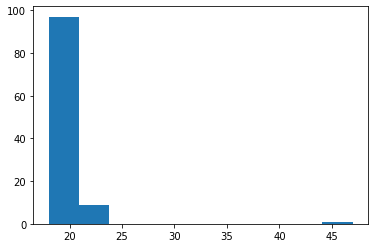

Women: 65
Men: 38
Other/did not report: 4


In [5]:
# Number in each group
lingNum = qualtricsData.groupby('Ling_or_Analog')['id'].count()['Ling']
analogNum = qualtricsData.groupby('Ling_or_Analog')['id'].count()['Analog']
print(f'Linguistic subjects: {lingNum}\nAnalog subjects: {analogNum}')

# Average age
print(f'Participants are {round(qualtricsData.age.mean(),2)} +/- {round(qualtricsData.age.std(),2)} years old')
plt.hist(qualtricsData.age)
plt.show()

# Number in each group
other = qualtricsData.groupby('gender')['id'].count()['other'] + \
        qualtricsData.groupby('gender')['id'].count()['genderqueer'] + \
        qualtricsData.groupby('gender')['id'].count()['do not wish to say'] + \
        qualtricsData.gender.isna().sum()
        
men = qualtricsData.groupby('gender')['id'].count()['man']
women = qualtricsData.groupby('gender')['id'].count()['woman']
print(f'Women: {women}\nMen: {men}\nOther/did not report: {other}')

# Did same answer for all SBSOD questions? 
# visualization for all people in cleaned data. 

# Remove all non-kept participants from masterData
masterData = masterData[masterData['participant'].isin(qualtricsData.id)]


masterData.to_csv(os.path.join(dataDir, "masterDataClean.csv"))

## Step 4. Load/calculate the drawing data for the analog task. 

This takes a while, so we'd rather load it unless there's a reason to recalculate. 

In [7]:
cleanLingData = True
cleanDrawingData = True
cleanTuningCurveData = True

if cleanLingData:
    
    
    # Assemble the linguistic coding data into analyzable form.
    # This function assigns a 1 if a direction was indicated by that participant
    # and a 0 if that direction was not selected. 
    def lingDirCheck(index,boxesChecked):
        global masterData
        for direction in ['ahead','left','sharp_left','slight_left','sharp_right','right','slight_right']:
            if 'trial_'+ direction + '_box' in boxesChecked:
                masterData.at[index,direction] = 1
            else:
                masterData.at[index,direction] = 0


    
    for index,row in masterData.iterrows():
    
        if not pd.isna(row['presentedImage']) and 'ling' in row['expName']:
            lingDirCheck(index,row['boxes_checked'])

    
    # Create a version of the data grouped by which images were presented
    lingDirectionsAverage = masterData.groupby(['presentedImage'])[['ahead','right','left','sharp_right','slight_right','slight_left','sharp_left']].mean()

    # In this version of the data, just a note that hedgemaze is all the same value. 
    lingDirectionsParticipant = masterData.groupby(['presentedImage','participant'])[['ahead','right','left','sharp_right','slight_right','slight_left','sharp_left']].mean()
    lingDirectionsAverage.to_csv(os.path.join(dataDir, "lingDirectionsAverage.csv"))    
    lingDirectionsParticipant.to_csv(os.path.join(dataDir, "lingDirectionsParticipant.csv"))

else:
    
    print('Ling data in loaded form. It will NOT be recalculated.')
    lingDirections = pd.read_csv(os.path.join(dataDir, "lingDirectionsAverage.csv"))
        
if cleanDrawingData:
    
    print('Drawing data being recalculated. This will take a while. Try adding more memory if it fails.')
    
    # Get names of images and set them as the columns of a new data frame. Drop the 'nan' column
    imageNames = masterData.presentedImage.unique().tolist()
    drawingData = pd.DataFrame(columns=imageNames)
    drawingData.drop(columns=[np.nan],inplace=True)

    # Loop through each row of masterData. 
    # If it's an analog trial and has a presentedImage, we run the helper function to process the drawing data.
    # The helper function will take in each row, plot the trace, then save it as a vector (1 where there is a path drawn, 0 otherwise). 
    # That vector will then be summed with all other traces over that image name. 
    for index,row in masterData.iterrows():
        if not pd.isna(row['presentedImage']) and 'analog' in row['expName']:
 
            masterData.at[index,'drawingFixed'] = literal_eval(row['drawing'])
            drawingData['temp'] = analogDirCheck(masterData, index, showPlot=False)
            tempDF = drawingData.loc[:,['temp',row['presentedImage']]].copy()

            # Do we have to normalize this by counting the number of subjects?
            drawingData.loc[:,row['presentedImage']] = tempDF.sum(axis=1)
            
    # Drop the last temp column then save file
    drawingData.drop(columns=['temp'],inplace=True)
    drawingData.to_csv(os.path.join(dataDir, "drawingData.csv"))

else:
    
    # Load the data and drop the unnamed column
    print('Analog data in loaded form. It will NOT be recalculated.')
    drawingData = pd.read_csv(os.path.join(dataDir, "drawingData.csv"))
    drawingData = drawingData.loc[:, ~drawingData.columns.str.contains('^Unnamed')]
    drawingData.drop(columns='hedgemaze1.jpg',inplace=True)

if cleanTuningCurveData:
    
    import glob
    
    N_TUNING_CURVES = [16,37,8]
    for i in N_TUNING_CURVES:
        analogFiles = glob.glob(os.path.join(dataDir,'individualAnalogData',f'*tuningCurves_{i}*'))

        analogDirectionsParticipant = pd.DataFrame()
        for f in analogFiles:
            a = pd.read_csv(f)
            # Get participant ID and apply it as a column
            id = f.split('/')[-1].split('_')[0]

            b = a.T
            b['participant'] = id
            b.rename_axis('presentedImage',inplace=True)
            b.reset_index(inplace=True)
            b.set_index(['presentedImage','participant'],inplace=True)
            analogDirectionsParticipant = pd.concat([analogDirectionsParticipant,b])
        
        analogDirectionsParticipant.to_csv(os.path.join(dataDir,f'analogData_{i}_bins_Participant.csv'))
        
        analogDirectionsAverage = analogDirectionsParticipant.groupby(['presentedImage']).mean()
        
        analogDirectionsAverage.to_csv(os.path.join(dataDir,f'analogData_{i}_bins_Average.csv'))


Drawing data being recalculated. This will take a while. Try adding more memory if it fails.


# Step 5. Run preprocesAnalogData.m

In [31]:
"""
Create individual participant linguistic dataframes (all analog dataframes are in 'tuningCurves' from Matlab).
This will generate all participant-level drawingData.csv files. After that, you can run  
"""
imageNames = masterData.presentedImage.unique().tolist() 
ids = masterData.participant.unique().tolist()
# For every participant, select their data, then create their analog vectors.
for i in ids:
    
    # Select the participant's data
    participantData = masterData[masterData.participant==i]
    
    # Create a template dataframe for each participant and reset it for each participant 
    drawingDataParticipant = pd.DataFrame(columns=imageNames)
    drawingDataParticipant.drop(columns=[np.nan],inplace=True)

    if not participantData['expName'].str.contains('analog').any():
        lingDirections = participantData.groupby(['presentedImage'])[['ahead','right','left','sharp_right','slight_right','slight_left','sharp_left']].sum()
        lingDirections = lingDirections[['sharp_left','left','slight_left','ahead','slight_right','right','sharp_right']]
        lingDirections.to_csv(os.path.join(data_dir, str(i) + '_lingData.csv'))
    else:
        
        for index,row in participantData.iterrows():
            if not pd.isna(row['presentedImage']) and 'analog' in row['expName']:
 
                participantData.at[index,'drawingFixed'] = literal_eval(row['drawing'])
                
                drawingDataParticipant['temp'] = analogDirCheck(participantData, index, showPlot=False)
                tempDF = drawingDataParticipant.loc[:,['temp',row['presentedImage']]].copy()

                # Do we have to normalize this by counting the number of subjects?
                drawingDataParticipant.loc[:,row['presentedImage']] = tempDF.sum(axis=1)
                
        # Save file
        drawingDataParticipant.drop(columns=['temp'],inplace=True)
        drawingDataParticipant.to_csv(os.path.join(data_dir,'participantDrawingData', f'drawingData_{i}.csv'))
        

In [72]:
import glob 

files = glob.glob(data_dir + '*ling*.csv',recursive=True)

def reformat_data(file_name):
    
    # Grab the subject ID from the filename
    subj_id = file_name.split('/')[-1][:5]
    
    # Transpose the table so we can use the image names as an index
    processed_data = pd.read_csv(file_name).set_index('presentedImage')
    
    # Drop the images that have no data (subjects did not provide responses to all images; only 100/500)
    #processed_data.dropna(inplace=True)
    # Reformat the index into a multi-index to refer to each image as its name and subject id
    processed_data = pd.concat({subj_id : processed_data}, names=['participant','image'])
    
    return processed_data

# Load the first data file
all_ling_data = reformat_data(files.pop(0))

# For the rest of the files, add them to the whole dataset
for file in files:
    subj_data = reformat_data(file)
    all_ling_data = pd.concat([all_ling_data,subj_data])


In [77]:
from scipy import spatial

ling_distance = pd.DataFrame(columns=['ling_distance'])

# For every participant
for i in all_ling_data.index.get_level_values('participant').unique():
    
    result_holder = pd.DataFrame(columns=['individual_dist'])
    # Get participant's data and everyone else's data separately
    all_ling_data = all_ling_data.sort_index(axis=0)
    
    #all_but = all_ling_data.drop((i), axis=0)
    
    participant_data = all_ling_data.loc[i]

    images = participant_data.index.get_level_values('image').unique().to_list()
    subj_ling_data = pd.DataFrame(index=images,columns=['ling_distance'])
    
    # For each image, calculate the distance between that subject's response and everybody else's response. 
    # Then average those distances
    for im in images:
        
        List1 = participant_data.loc[im].to_list()
        
        for j in all_ling_data.index.get_level_values('participant').unique():
            if j is not i and im in all_ling_data.loc[j].index.to_list():
                
                List2 = all_ling_data.loc[(j,im)].to_list()
                
                result_holder.loc[j] = scipy.spatial.distance.pdist([List1, List2],'hamming')[0]
            
        subj_ling_data.loc[im]['ling_distance'] = result_holder.mean()

    # This is the value of each subjects' similarity with the average linguistic response of all other subjects
    ling_distance.loc[i] = subj_ling_data['ling_distance'].mean()
    

## Step 4b. Define a helper function to plot images. 

In [8]:
# Plots path to corresponding image
def plotTrace(drawingData, folderpath, filename, saveFig=False, outputDir=None):
    """
    Filler
    """
    # Reshape vector into 2d 100x100 form
    trace = np.reshape(drawingData.loc[:,filename].values,(100,100))
    trace1 = np.copy(trace)

    # Mask the trace so anywhere that's a 0 won't be plotted.
    trace1 = np.ma.masked_where(trace1==0, trace1)

    # Set figure
    fig, ax = plt.subplots()

    # Plot the image
    img = mpimg.imread(os.path.join(folderpath, filename))

    # We have to re-map the image so it doesn't plot upside down.
    ax.imshow(img,extent=(10,90,90,10))
    
    # Plot the trace, making it slightly transparent
    cax = ax.matshow(trace1,alpha=.6,cmap='autumn')
    
    # Turn the axis off
    ax.axis('off')

    if saveFig:
        if not outputDir:
            raise NameError('No output directory specified.')
        else:
            fig.savefig(os.path.join(outputDir,filename))
        
    else:
        
        # Plot the colorbar
        cbar = fig.colorbar(cax)
        current_cmap = cm.get_cmap()
        current_cmap.set_bad(alpha=0,color='red')
        ax.set_xlim(10,90)
        ax.set_ylim(90,10)

        plt.show()
    

<ipython-input-8-00d7ba59f0d9>:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  current_cmap.set_bad(alpha=0,color='red')


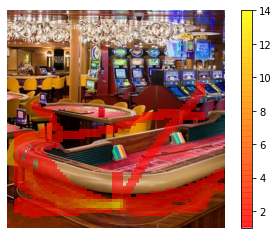

In [9]:
# Print a sample image! 
image_name = 'casino3.jpg'
image_path = os.path.join(stimDir,'Image_List_2')

# You can save it, if you specify outputDir here. You can also do this for all images below
outputDir = os.path.join(baseDir,'BOLD5000_Stimuli_Traces')

if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

plotTrace(drawingData, image_path, image_name, saveFig=False, outputDir=outputDir)

## Step 5. Save overlays of images with traces. 

This takes a while and takes a lot of space, so we'd rather load it unless there's a reason to recalculate. 

In [10]:
createAnalogImages = False

# If you set this to true, where do you want the images saved?
outputDir = os.path.join(baseDir,'BOLD5000_Stimuli_Traces')

if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

if createAnalogImages:
    
    print('Recreating images. This will be a while.')
    
    # Helper function to get all file names
    folderPathList = [os.path.join(stimDir,'Image_List_1'),
                      os.path.join(stimDir,'Image_List_2'),
                      os.path.join(stimDir,'Image_List_3'),
                      os.path.join(stimDir,'Image_List_4'),
                      os.path.join(stimDir,'Image_List_5')]

    # Returns nested lists of the filenames within each folder given
    # Takes a list of folder paths, loops through this list, and 
    # Returns nested lists of the filenames within each folder given
    def getFileNames(folderPathList, sort = False, ext = '.jpg'):

        nameList = []

        # Creates 2D list sorting relevant file names by corresponding folder
        if sort:

            # Loops through the folder paths you've given and gets filenames in folder
            for folder in folderPathList:
                col = [] #The inner List
                file_names = os.listdir(folder)

                for name in file_names:
                    # Only add file names to nameList that end with '.jpg'
                    if name.endswith(ext):  #This is optional check for .jpg file
                        col.append(name)      
                nameList.append(col)

        # Returns 1D List of all relevant filenames
        # Else returns multiple 1D Lists of all filenames
        else:

            # Loops through the folder paths you've given and gets filenames in folder
            for folder in folderPathList:
                file_names = os.listdir(folder)

                for name in file_names:

                    # Only add file names to nameList that end with '.jpg' (optional)
                    if name.endswith(ext):  
                        nameList.append(name)

        #Return aggregate list of all applicable filenames
        return nameList 

    # Get the list of simuli
    nameList = getFileNames(folderPathList,True)


    # Runs the function for each image in the provided folder paths
    for i in range(len(nameList)):
        for j in range(len(nameList[i])):
            plotTrace(drawingData, folderPathList[i], nameList[i][j], saveFig=createAnalogImages, outputDir=outputDir)
            

# Data Analysis

In [ ]:

analogPlot, analogIdx = cluster_corr(drawingData.corr(),3)
sns.heatmap(analogPlot)
plt.title('Analog')
plt.show()

lingPlot, lingIdx = cluster_corr(lingDirections.T.corr(),3)
sns.heatmap(lingPlot)
plt.title('Categorical')
plt.show()


In [ ]:
# Reshape ling correlation matrix into 1d
corrDF = lingCorrMatrix.rename_axis(None).rename_axis(None, axis=1)
corrDF = corrDF.stack().reset_index()

# Set column names
corrDF.columns = ['img1','img2','lingCorr']
corrDF.sort_values(by=['img1','img2'],inplace=True)

# Add analog directions
analogDirectionsSorted = analogCorrMatrix.rename_axis(None).rename_axis(None, axis=1)
analogDirectionsSorted = analogDirectionsSorted.stack().reset_index()
analogDirectionsSorted.columns = ['img1','img2','analogCorr']
analogDirectionsSorted.sort_values(by=['img1','img2'],inplace=True)


# Combine them
corrDF['analogCorr'] = analogDirectionsSorted['analogCorr']

ana_ling_corr, ana_ling_p = stats.spearmanr(corrDF['lingCorr'],corrDF['analogCorr'])

print(f"Spearman's correlation = {ana_ling_corr:0.3f}, p = {ana_ling_p:0.6f}")

In [ ]:
plt.scatter(corrDF['lingCorr'],corrDF['analogCorr'],alpha=.1)

In [11]:
# Load each subjs. brain data into memory
def loadSubjectBrainData(subject,TR):
    stimListSubjID = subject[:3] + '0' + subject[3:]
    subjMat = scipy.io.loadmat('/blue/stevenweisberg/share/catscenes/BOLD5000_ROIs/ROIs/'
                               + subject + '/mat/' 
                               + subject + '_ROIs_TR' + TR + '.mat')
    stimList = pd.read_csv('/blue/stevenweisberg/share/catscenes/BOLD5000_ROIs/ROIs/stim_lists/' + 
                           stimListSubjID + '_stim_lists.txt', header=None)
    return subjMat,stimList




In [45]:
# A function that will calculate the brain and behavioral correlations for each subj., TR, and brain region
def calculateBrainBehaviorCorrelations(ling1D, analog1D, presentedImages, subjects, TRs, brainRegions):
    
    # Create multi-index
    subjectsInd = np.repeat(subjects,len(TRs))
    TRsInd = np.tile(TRs,len(subjects))
    behavioralInd = np.tile(['analog','ling','partial'],len(TRs)*len(subjects))
    arrays = [subjectsInd,TRsInd,behavioralInd]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=["subjects", "TRs", "behavioralMeasure"])
    
    brainCorr = pd.DataFrame(columns=brainRegions,index=index)
    
    for subject in subjects:        
        print(subject)
        for TR in TRs:
            print(TR)
            subjMat,stimList = loadSubjectBrainData(subject,TR)            
            for region in brainRegions:
                regionMat = pd.DataFrame(subjMat[region].T,columns=stimList.iloc[:,0])
                regionMat = regionMat[regionMat.columns.intersection(presentedImages.iloc[:,0])]
                regionCorr = regionMat.corr()
                regionCorr.sort_index(inplace=True,axis=0)
                regionCorr.sort_index(inplace=True,axis=1)
                
                plt.imshow(regionCorr,cmap='autumn')
                plt.colorbar()
                plt.show()
                regionCorrNP = regionCorr.to_numpy()
                regionCorr1D = np.empty(regionCorrNP.size)
                regionCorr1D = np.reshape(regionCorrNP,regionCorrNP.size)
                
                dfPartial['brain'] = regionCorr1D
                
                brainCorr.at[(subject,TR,'analog'),region] = stats.spearmanr(analog1D,regionCorr1D)[0]
                brainCorr.at[(subject,TR,'ling'),region] = stats.spearmanr(ling1D,regionCorr1D)[0]
                
    return brainCorr
    

CSI1
1


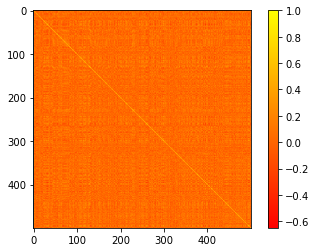

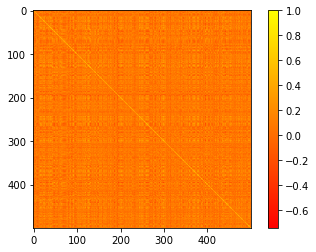

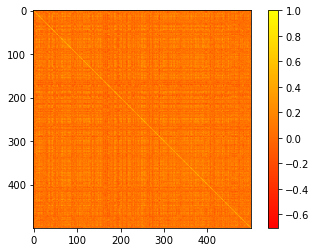

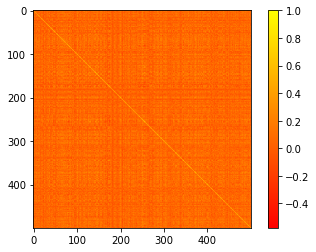

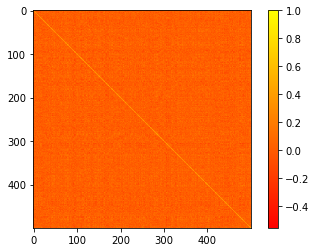

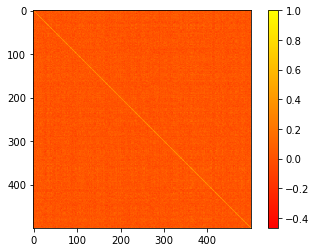

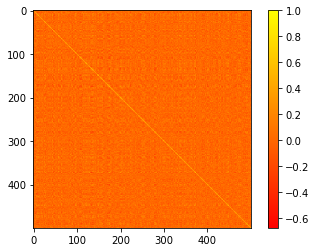

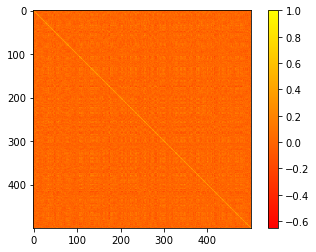

2


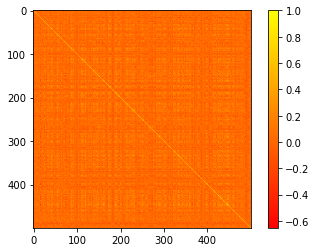

/apps/python/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):


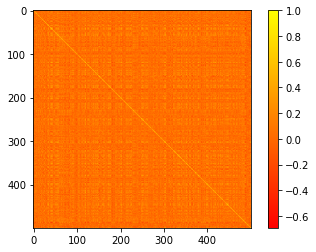

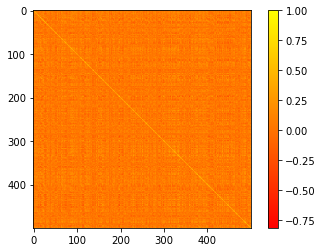

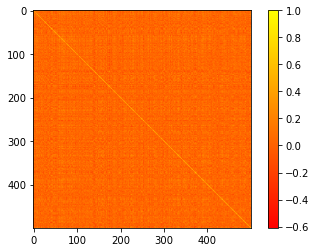

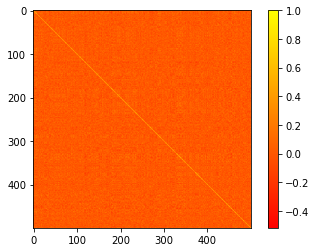

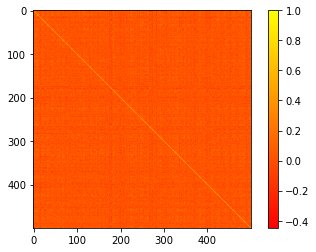

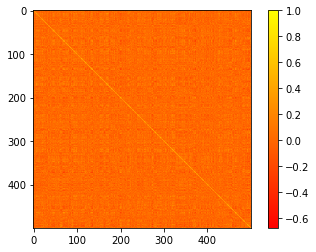

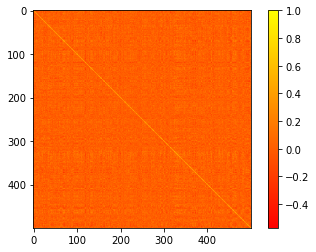

3


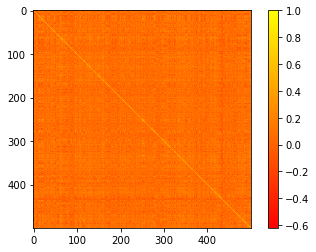

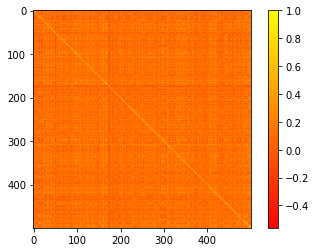

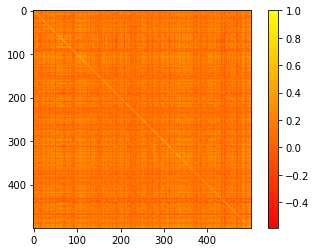

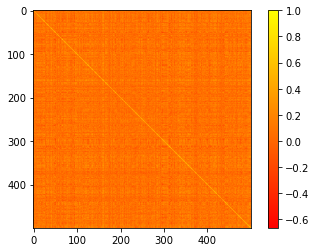

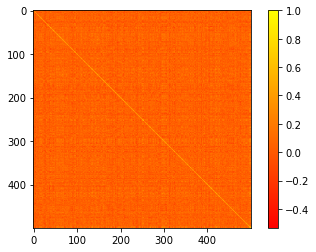

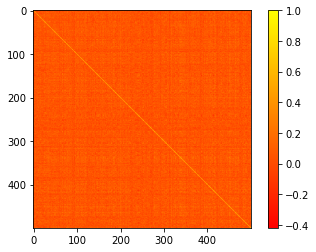

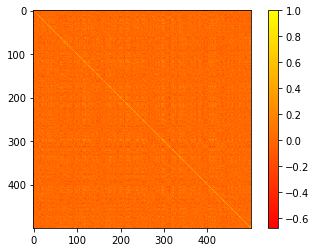

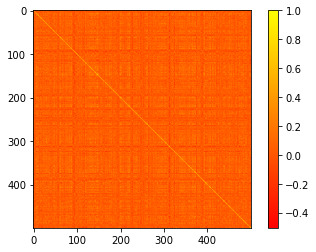

KeyboardInterrupt: 

In [46]:

presentedImages = pd.DataFrame(masterData['presentedImage'].unique()).dropna()

dfPartial = pd.DataFrame({'analog':analog1D,'ling':ling1D})
plt.hist(dfPartial.ling)


subjects = ['CSI1','CSI2','CSI3']

TRs = ['1','2','3','4','5','34']

brainRegions = ['LHEarlyVis','RHEarlyVis','LHOPA','RHOPA','LHPPA','RHPPA','LHRSC','RHRSC']



brainCorr = calculateBrainBehaviorCorrelations(ling1D, analog1D, presentedImages, subjects, TRs, brainRegions)

col = brainCorr.loc[: , ["LHEarlyVis","RHEarlyVis"]]
brainCorr['EVC_mean'] = col.mean(axis=1)

col = brainCorr.loc[: , ["LHOPA","RHOPA"]]
brainCorr['OPA_mean'] = col.mean(axis=1)

col = brainCorr.loc[: , ["LHPPA","RHPPA"]]
brainCorr['PPA_mean'] = col.mean(axis=1)

col = brainCorr.loc[: , ["LHRSC","RHRSC"]]
brainCorr['RSC_mean'] = col.mean(axis=1)

brainCorrBiLat = brainCorr[['EVC_mean', 'OPA_mean','PPA_mean','RSC_mean']].copy()

brainCorr.drop(['EVC_mean', 'OPA_mean','PPA_mean','RSC_mean'],axis=1,inplace=True)

brainCorrToPlot=brainCorr.stack([0]).reset_index(name='correlation')
brainCorrToPlot.correlation = brainCorrToPlot.correlation.astype(float)
brainCorrToPlot.rename(columns={'level_3':'ROI'},inplace=True)


brainCorrBiLatToPlot=brainCorrBiLat.stack([0]).reset_index(name='correlation')
brainCorrBiLatToPlot.correlation = brainCorrBiLatToPlot.correlation.astype(float)
brainCorrBiLatToPlot.rename(columns={'level_3':'ROI'},inplace=True)





In [38]:
brainCorr

LHEarlyVis RHEarlyVis     LHOPA     RHOPA  \
subjects TRs behavioralMeasure                                             
CSI1     1   analog             -0.000744   -0.00111 -0.002319 -0.001552   
         2   ling                 0.00208   0.002552  0.002242   0.00097   
         3   partial                  NaN        NaN       NaN       NaN   
         4   analog             -0.000042   0.003077  0.000352  0.000955   
         5   ling               -0.002744  -0.002744 -0.004261  0.000796   
         34  partial                  NaN        NaN       NaN       NaN   
CSI2     1   analog             -0.000555  -0.001747   0.00169 -0.000276   
         2   ling                0.001009   0.000683  0.000722  0.000368   
         3   partial                  NaN        NaN       NaN       NaN   
         4   analog             -0.001905  -0.003091  0.002329 -0.001119   
         5   ling               -0.000138  -0.000804 -0.002283  0.000278   
         34  partial                  NaN        NaN       NaN       NaN   
CSI3     1   analog              0.000982  -0.001878  0.001803 -0.003148   
         2   ling               -0.000275  -0.002326 -0.001859  0.001218   
         3   partial                  NaN        NaN       NaN       NaN   
         4   analog              0.000371  -0.003001   0.00152 -0.003746   
         5   ling                0.002522   0.003068  0.001459  0.001223   
         34  partial                  NaN        NaN       NaN       NaN   
CSI1     1   ling                0.001146  -0.002125  0.001483  0.003473   
         2   analog             -0.000901  -0.002216 -0.000446 -0.002062   
         3   analog              0.002266   0.002114  0.004173  0.001138   
             ling               -0.003901   0.000368 -0.002168 -0.000586   
         4   ling               -0.002298  -0.000468 -0.004287 -0.003654   
         5   analog              0.001033   0.000477 -0.000214 -0.000533   
         34  analog              0.000834   0.002171  0.001689 -0.000283   
             ling               -0.000072     0.0028 -0.002908 -0.001764   
CSI2     1   ling                -0.00165    0.00087  0.001177 -0.002786   
         2   analog              0.001871   0.001139 -0.005173 -0.000157   
         3   analog              0.000569  -0.000879 -0.006785  -0.00261   
             ling                -0.00179  -0.004137  0.001329 -0.000977   
         4   ling                 0.00355   0.000819 -0.001893  -0.00043   
         5   analog             -0.000023  -0.002312 -0.000761  0.000788   
         34  analog             -0.002652  -0.004128 -0.000521 -0.002097   
             ling                0.000532  -0.002192  0.000524 -0.001007   
CSI3     1   ling               -0.000466   0.000214   -0.0023  0.001974   
         2   analog             -0.001544  -0.001197 -0.000077 -0.000368   
         3   analog             -0.002352  -0.002028 -0.002399 -0.002277   
             ling                0.000554    -0.0008 -0.000445   0.00012   
         4   ling               -0.000085  -0.000631 -0.000016  0.000571   
         5   analog              -0.00027    0.00306  0.001462 -0.001603   
         34  analog             -0.003485  -0.003116 -0.000192 -0.003438   
             ling                0.000393  -0.000246  0.001139 -0.001279   

                                   LHPPA     RHPPA     LHRSC     RHRSC  
subjects TRs behavioralMeasure                                          
CSI1     1   analog            -0.001337 -0.000143 -0.001594  0.001158  
         2   ling               -0.00113 -0.004187  0.000364  0.001657  
         3   partial                 NaN       NaN       NaN       NaN  
         4   analog             -0.00265  -0.00155  0.000317 -0.000847  
         5   ling              -0.002265 -0.004025 -0.002834 -0.001985  
         34  partial                 NaN       NaN       NaN       NaN  
CSI2     1   analog             0.003445  0.001122  0.001398 -0.000897  
         2   ling            

In [34]:
analog = brainCorrBiLatToPlot[brainCorrBiLatToPlot['behavioralMeasure']=='analog']
ling = brainCorrBiLatToPlot[brainCorrBiLatToPlot['behavioralMeasure']=='ling']

for TR in TRs:
    for roi in ['EVC_mean','OPA_mean','PPA_mean','RSC_mean']:
        analogSubsample = analog[analog['TRs']==TR]
        lingSubsample = ling[ling['TRs']==TR]
        analogSubsample = analogSubsample[analogSubsample['ROI']==roi]
        lingSubsample = lingSubsample[lingSubsample['ROI']==roi]
        crossCorrel = stats.ttest_rel(analogSubsample.correlation,lingSubsample.correlation)
        print(f'Cross correlation = TR {TR}, roi {roi}, t = {crossCorrel[0]:.3}, p = {crossCorrel[1]:.3}')
        
        analogCorrel = stats.ttest_1samp(analogSubsample.correlation,0)
        print(f'Analog: TR {TR}, roi {roi}, t = {analogCorrel[0]:.3}, p = {analogCorrel[1]:.3}')
        
        lingCorrel = stats.ttest_1samp(lingSubsample.correlation,0)
        print(f'Ling: TR {TR}, roi {roi}, t = {lingCorrel[0]:.3}, p = {lingCorrel[1]:.3}')
        

Cross correlation = TR 1, roi EVC_mean, t = -3.86, p = 0.061
Analog: TR 1, roi EVC_mean, t = -4.07, p = 0.0554
Ling: TR 1, roi EVC_mean, t = -3.08, p = 0.0912
Cross correlation = TR 1, roi OPA_mean, t = -0.654, p = 0.58
Analog: TR 1, roi OPA_mean, t = -0.829, p = 0.494
Ling: TR 1, roi OPA_mean, t = 0.502, p = 0.665
Cross correlation = TR 1, roi PPA_mean, t = 0.0984, p = 0.931
Analog: TR 1, roi PPA_mean, t = 0.626, p = 0.595
Ling: TR 1, roi PPA_mean, t = 0.253, p = 0.824
Cross correlation = TR 1, roi RSC_mean, t = -0.898, p = 0.464
Analog: TR 1, roi RSC_mean, t = -0.954, p = 0.441
Ling: TR 1, roi RSC_mean, t = 0.386, p = 0.737
Cross correlation = TR 2, roi EVC_mean, t = -0.78, p = 0.517
Analog: TR 2, roi EVC_mean, t = -0.479, p = 0.679
Ling: TR 2, roi EVC_mean, t = 0.591, p = 0.614
Cross correlation = TR 2, roi OPA_mean, t = -1.9, p = 0.198
Analog: TR 2, roi OPA_mean, t = -1.95, p = 0.191
Ling: TR 2, roi OPA_mean, t = 1.09, p = 0.388
Cross correlation = TR 2, roi PPA_mean, t = 0.382, p 

In [26]:
shuffles = np.arange(10)
shuffleLing1D = np.copy(ling1D)
shuffleAnalog1D = np.copy(analog1D)

np.random.shuffle(shuffleLing1D)

for i in shuffles:
    np.random.shuffle(shuffleLing1D)
    np.random.shuffle(shuffleAnalog1D)

    shuffleCorr[i] = calculateBrainBehaviorCorrelations(shuffleLing1D, shuffleAnalog1D, presentedImages, subjects, TRs, brainRegions)


CSI1
1
2
3
4
5
34
CSI2
1
2
3
4
5
34
CSI3
1
2
3
4
5
34


NameError: name 'shuffleCorr' is not defined

In [18]:
np.corrcoef(analog1D,ling1D)

array([[1.        , 0.20342003],
       [0.20342003, 1.        ]])

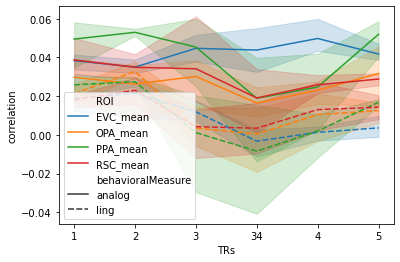

In [20]:


fig2 = sns.lineplot(x="TRs", y="correlation",
             hue="ROI",style='behavioralMeasure'
             ,data=brainCorrBiLatToPlot,n_boot=1000)






In [ ]:
subjMat